In [372]:
!pip install wfdb
import wfdb
import pandas as pd
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks, resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [373]:
np.random.seed(0)

##Wczytanie danych

In [374]:
def get_data(path, amount): 
  """
  Wczytanie danych z plikow w folderze.

  Parameters
  ----------
  path : str
    Sciezka do folderu.
  amount : int
    Ilosc plikow do wczytania.

  Returns
  -------
  data : list of list
    Wczytane sygnaly PPG.
  dic : dict of str
    Zaindeksowane nazwy plikow.
  """
  data = []
  dic = {}
  index = 0
  for f in glob.glob(path):
    if f.endswith('.hea') == True:
      print("Wczytuje plik: ",f)
      name = f[-9:-4] if f[-10]=="s" else f[-10:-4]
      sig, fields = wfdb.rdsamp(f[:len(f)-4])
      data.append(make_data(sig))
      dic[index] = name
      index+=1
      if index==amount:
        return data, dic
  return data, dic

def make_data(sig):
  """
  Przetworzenie danych (usuniecie wartosci NaN).

  Parameters
  ----------
  sig : numpy.ndarray 
    Sygnal PPG.

  Returns
  -------
  clean_sig : list
    Sygnal PPG po oczyszczeniu.
  """
  data = []
  for p in sig:
    data.append(p[1]) 
  clean_data = pd.DataFrame(data).dropna()
  
  return clean_data[0].values.tolist()

In [375]:
path = "/content/drive/MyDrive/data/datab/*"

data, dic = get_data(path, 10)
index = 2

Wczytuje plik:  /content/drive/MyDrive/data/datab/s9_walk.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s8_run.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s8_walk.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s5_run.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s6_walk.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s3_run.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s3_walk.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s6_run.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s1_walk.hea
Wczytuje plik:  /content/drive/MyDrive/data/datab/s2_walk.hea


##Implementacja funkcji oceniających metody

In [376]:
def plot_result(plot_type,ppg,ppg_new,text):
  """
    Funkcja wykreślająca wykresy.

    Parameters
    ----------
    plot_type : bool 
      Określa który wykres będzie rysowany.
    ppg : list 
      Sygnał PPG nieodszumiony.
    ppg_new : list 
      Sygnał PPG odszumiony.
    text : list of str
      Lista podpisów wykresu.

    Returns
      None
    -------
 
  """
  if plot_type==None:
      pass
  elif plot_type:
      plt.figure(figsize=(6, 4), dpi=120)
      plt.plot(ppg,label=text[0])
      plt.xlabel('time (s)')
      plt.ylabel('microvolts (uV)')
      plt.title(text[1])
      plt.plot(ppg_new,label=text[2])
      plt.xlim([1000,2000])
      plt.legend()
      plt.tight_layout()
      plt.show()
  elif not plot_type:
      plt.figure(figsize=(6, 4), dpi=150)
      plt.subplot(2, 1, 1)
      plt.plot(ppg)
      plt.xlabel('time (s)')
      plt.ylabel('microvolts (uV)')
      plt.title(text[0])
      plt.xlim([1000,2000])
      plt.subplot(2, 1, 2)
      plt.plot(ppg_new)
      plt.xlabel('time (s)')
      plt.ylabel('microvolts (uV)')
      plt.title(text[2])
      plt.xlim([1000,2000])
      plt.tight_layout()
      plt.show()

def get_metrics(sig_orig, sig_new):
  """
    Obliczenie miar jakości odszumienia sygnału PPG.

    Parameters
    ----------
    sig_orig : numpy.ndarray
        Sygnał PPG przed odszumieniem.
    sig_new : numpy.ndarray
        Sygnał PPG po odszumieniu.
    
    Returns
    -------
    snr : float
        Miara SNR.
    mse : float
        Miara MSE.
    mae : float
        Miara MAE.
  """
  snr = signal_to_noise(sig_orig, sig_new)
  mse = mean_squared_error(sig_orig, sig_new)
  mae = mean_absolute_error(sig_orig, sig_new)
  print(f"\n\nMetryki dla badanego sygnalu: \nSNR: {snr}, MSE: {mse}, MAE: {mae},\n\n")
  return snr, mse, mae

def signal_to_noise(sig_orig, sig_new):
  """
    Obliczenie miary SNR dla sygnału PPG.

    Parameters
    ----------
    sig_orig : numpy.ndarray
      Sygnał PPG przed odszumieniem.
    sig_new : numpy.ndarray
      Sygnał PPG po odszumieniu.

    Returns
    -------
    snr : float
      Miara SNR.
  """
  numerator = sum([so**2 for so in sig_orig])/len(sig_orig)
  denominator = sum([(so-sn)**2 for so, sn in zip(sig_orig, sig_new)])/len(sig_orig)
  snr = 10*np.log10(numerator/denominator)
  return snr

def dis(val):
  """
    Zaokrąglenie wartości do 3 miejsc po przecinku.

    Parameters
    ----------
    val : float
      Wartość przed zaokrągleniem.

    Returns
    -------
    text : string
      Wartość po zaokrągleniu.
  """
  text = "%.3f" % round(val,3)
  return text

def test_method(method, data, dic):
  """
    Sprawdzenie miar jakości dla wybranej metody na podstawie wybranych sygnałów.

    Parameters
    ----------
    method : func
      Funkcja implementująca metodę odszumiania.
    data : list of list
      Sygnały PPG przeznaczone do odszumienia.
    dic : dict of str
      Zaindeksowane nazwy plikow.

    Returns
    -------
    df : pandas.Dataframe
        Zebrane miary jakości.
  """
  df = pd.DataFrame(columns=['Signal', 'SNR', 'MSE', 'MAE'])
  for i, d in enumerate(data):
    method_data, snr, mse, mae = method(d, None, None)
    row = {'Signal': dic[i], 'SNR': dis(snr), 'MSE': dis(mse), 'MAE': dis(mae)}
    df = df.append(row, ignore_index=True)
  return df

##Metody

###Przetwarzanie

In [377]:
def ppg_cutting(ppg):
  """
  Podzial sygnalu na fragmenty wzgledem maksimum.

  Parameters
  ----------
  ppg : list of list
    Sygnaly PPG.

  Returns
  -------
  new_data : list of list
    Sygnal PPG po podziale na fragmenty.
  """
  new_data = []
  peaksup_list, avg_dist = get_avg(ppg)
  for signal,peaks in zip(ppg,peaksup_list):
      new_data.append([resample(signal[peaks[i]:peaks[i+1]],
                                avg_dist) for i in range(len(peaks)-1)])
  return new_data

def get_avg(ppg):
  """
  Wyznaczenie maksimow oraz sredniej dlugosci odcinka sygnalu.

  Parameters
  ----------
  ppg : list of list
    Sygnaly PPG.

  Returns
  -------
  peaksup_list : list of list
    Lista wyznaczonych maksimow.
  avg : int
    Srednia dlugosc odcinka sygnalu.
  """
  peaksup_list = []
  dist = []
  for signal in ppg:
    peaksup, p = find_peaks(signal,distance=150)
    peaksup_list.append(peaksup)
    dist.extend([peaksup[i+1]-peaksup[i] for i in range(len(peaksup)-1)])
  avg = int(np.mean(dist) + 0.5)
  return peaksup_list, avg

def get_all_data(data):
  """
  Zlaczenie odcinkow sygnalu.

  Parameters
  ----------
  data : list of list
    Sygnaly PPG.

  Returns
  -------
  new_data : list of list
    Lista polaczonych sygnalow.
  """
  new_data = []
  for i in data:
    new_data.extend(i)
  return new_data

In [378]:
cut_ppg = ppg_cutting(data)

###PCA

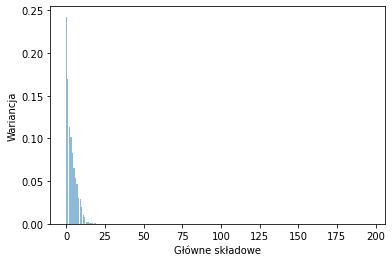

In [379]:
pca = PCA()
pca.fit_transform(cut_ppg[2])
exp_var = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.bar(range(len(exp_var)), exp_var, alpha=0.5, align='center')
plt.ylabel('Wariancja')
plt.xlabel('Główne składowe')
plt.show()

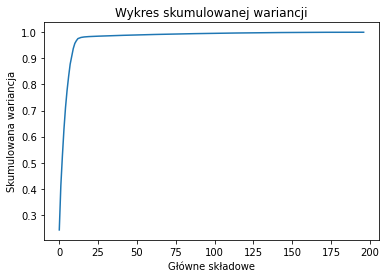

In [380]:
pca = PCA().fit(cut_ppg[2])
variance_r = np.cumsum(pca.explained_variance_ratio_)
plt.plot(variance_r)
plt.xlabel('Główne składowe')
plt.ylabel('Skumulowana wariancja')
plt.title("Wykres skumulowanej wariancji")
plt.show()

In [381]:
def PCA_method(ppg,plot_type,text):
    """
    Odszumienie metoda PCA.

    Parameters
    ----------
    plot_type : bool 
      Okresla, ktory wykres bedzie rysowany.
    ppg : list of list
      Sygnaly PPG.
    text : list of str
      Lista podpisow wykresu.

    Returns
    -------
    pca_data : list of list
      Sygnal PPG po odszumieniu metoda PCA.
    snr : float
      Wartosc SNR.
    mse : float
      Wartosc MSE.
    mae : float
      Wartosc MAE.
    """
    pca = PCA(n_components = 20).fit(ppg)
    transform_data = pca.transform(ppg)
    pca_data = pca.inverse_transform(transform_data)
    snr, mse, mae = get_metrics(get_all_data(ppg), get_all_data(pca_data))
    plot_result(plot_type,get_all_data(ppg),get_all_data(pca_data),text)
    return pca_data, snr, mse, mae



Metryki dla badanego sygnalu: 
SNR: 38.87578210835224, MSE: 257.6062052490979, MAE: 13.251009539914007,




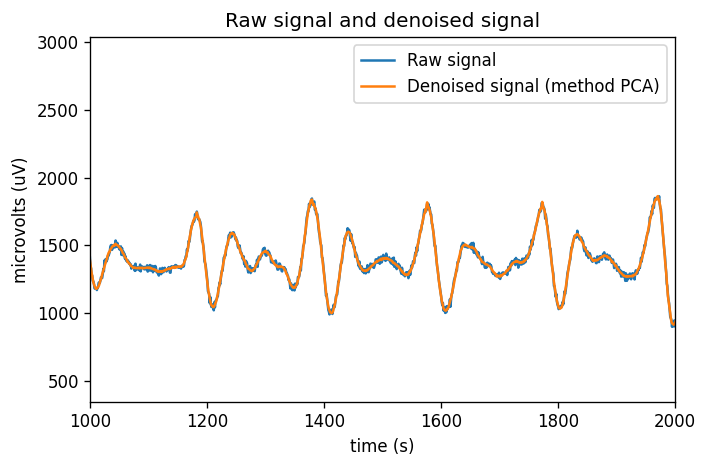



Metryki dla badanego sygnalu: 
SNR: 38.876447843899946, MSE: 257.56671949198744, MAE: 13.251454126259967,




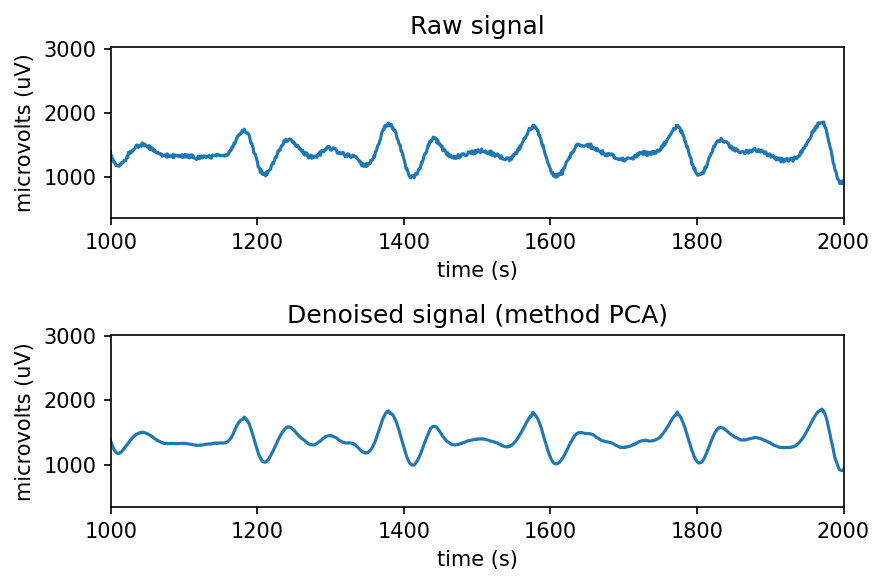

In [382]:
text_pca = ['Raw signal','Raw signal and denoised signal','Denoised signal (method PCA)']
pca_data,snr_pca,mse_pca,mae_pca = PCA_method(cut_ppg[index],True,text_pca)
pca_data,snr_pca,mse_pca,mae_pca = PCA_method(cut_ppg[index],False,text_pca)

###ICA

In [383]:
def ICA_method(ppg,plot_type,text):
    """
    Odszumienie metoda ICA.

    Parameters
    ----------
    plot_type : bool 
      Okresla, ktory wykres bedzie rysowany.
    ppg : list of list
      Sygnaly PPG.
    text : list of str
      Lista podpisow wykresu.

    Returns
    -------
    ica_data : list of list
      Sygnal PPG po odszumieniu metoda ICA.
    snr : float
      Wartosc SNR.
    mse : float
      Wartosc MSE.
    mae : float
      Wartosc MAE.
    """
    ica = FastICA(n_components = 32, random_state=12).fit(ppg)
    transform_data = ica.transform(ppg)
    transform_data[:, 1] = 0
    ica_data = ica.inverse_transform(transform_data)
    snr, mse, mae = get_metrics(get_all_data(ppg), get_all_data(ica_data))
    plot_result(plot_type,get_all_data(ppg),get_all_data(ica_data),text)
    return ica_data, snr, mse, mae

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)




Metryki dla badanego sygnalu: 
SNR: 36.18247749737905, MSE: 478.94625444506966, MAE: 15.04167625488959,




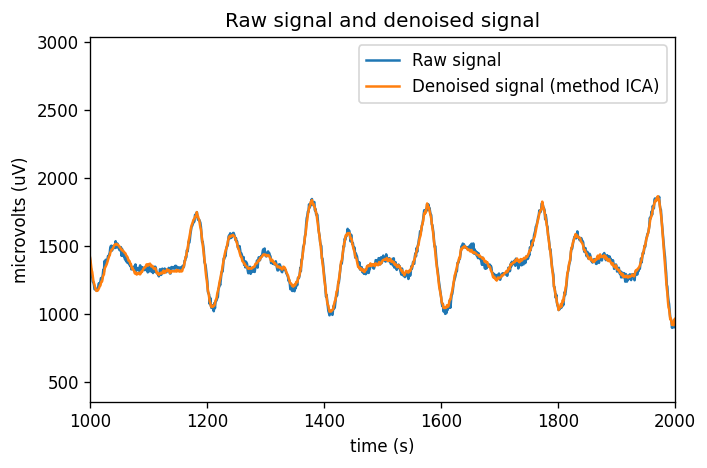

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)




Metryki dla badanego sygnalu: 
SNR: 36.18247749737905, MSE: 478.94625444506966, MAE: 15.04167625488959,




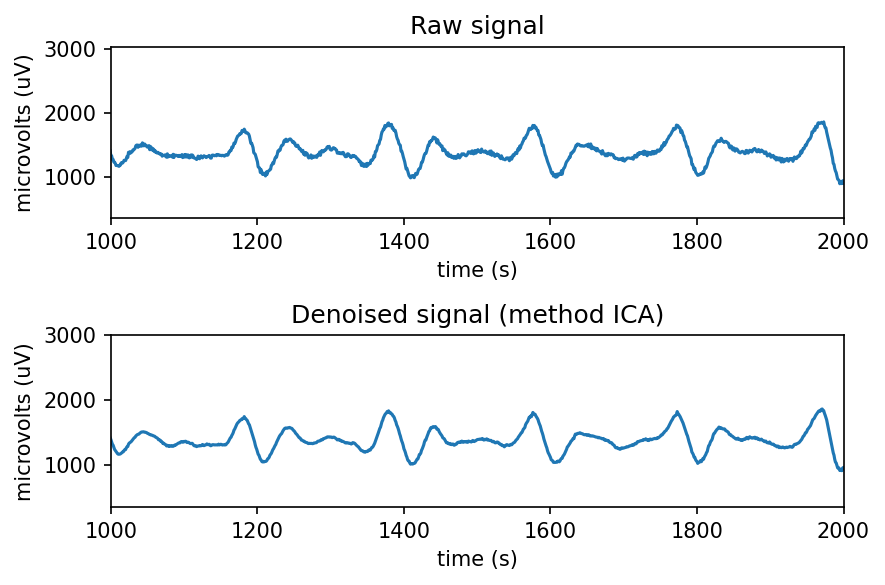

In [398]:
text_ica = ['Raw signal','Raw signal and denoised signal','Denoised signal (method ICA)']
ica_data = ICA_method(cut_ppg[index],True, text_ica)
ica_data = ICA_method(cut_ppg[index],False, text_ica)

###Transformata Falkowa

In [385]:
def DWT_method(ppg,plot_type,text):
    """
    Odszumienie metodA DWT.

    Parameters
    ----------
    plot_type : bool 
      Okresla, ktory wykres bedzie rysowany.
    ppg : list of list
      Sygnaly PPG.
    text : list of str
      Lista podpisow wykresu.

    Returns
    -------
    DWT_ppg : list of list
      Sygnal PPG po odszumieniu metoda DWT.
    snr : float
      Wartosc SNR.
    mse : float
      Wartosc MSE.
    mae : float
      Wartosc MAE.
    """
    wave = 'coif3'
    level = 8
    threshold = 0.01

    coeffs = pywt.wavedec(ppg, wave,level=level)

    all_max = [np.max(i) for i in coeffs[1:]]
    mean_max = np.mean(all_max)  

    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*mean_max)

    DWT_ppg = pywt.waverec(coeffs, wave)
    DWT_ppg = DWT_ppg if len(DWT_ppg)== len(ppg) else DWT_ppg[:-1]
    snr, mse, mae = get_metrics(ppg, DWT_ppg)
    plot_result(plot_type,ppg, DWT_ppg,text)
    return DWT_ppg, snr, mse, mae



Metryki dla badanego sygnalu: 
SNR: 39.735929933175676, MSE: 211.3114553257855, MAE: 11.929611075603079,




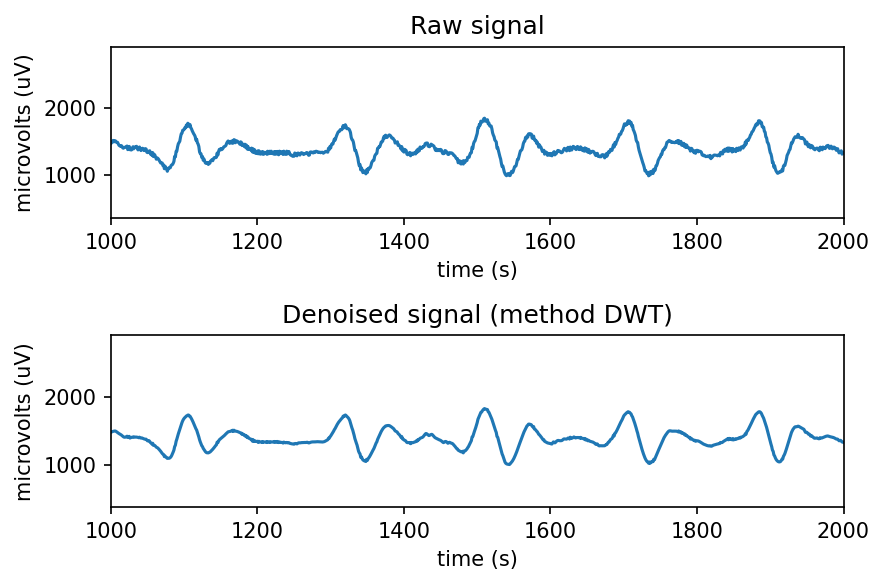



Metryki dla badanego sygnalu: 
SNR: 39.735929933175676, MSE: 211.3114553257855, MAE: 11.929611075603079,




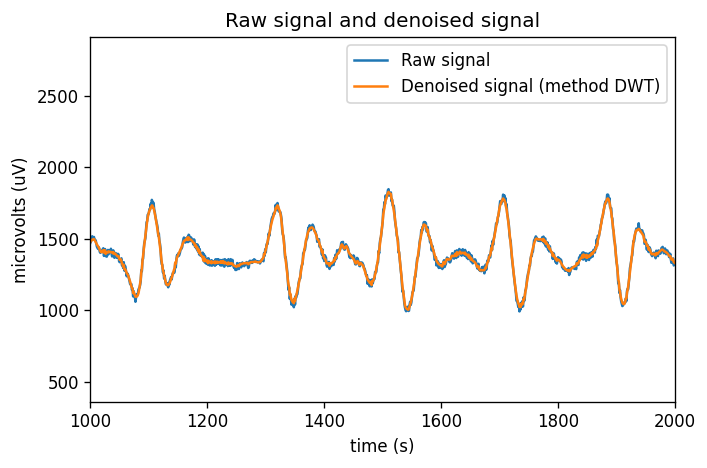

In [386]:
text_dwt = ['Raw signal','Raw signal and denoised signal','Denoised signal (method DWT)']
dwt_data,snr_dwt,mse_dwt,mae_dwt = DWT_method(data[index],False,text_dwt)
dwt_data,snr_dwt,mse_dwt,mae_dwt = DWT_method(data[index],True,text_dwt)

##Ocena rezultatów

In [387]:
df_pca = test_method(PCA_method, cut_ppg, dic)



Metryki dla badanego sygnalu: 
SNR: 39.19785353333536, MSE: 240.19337961184692, MAE: 12.748812597913329,




Metryki dla badanego sygnalu: 
SNR: 38.610434092018515, MSE: 275.9165469551281, MAE: 13.540524315753789,




Metryki dla badanego sygnalu: 
SNR: 38.8763120028548, MSE: 257.5747759331875, MAE: 13.250626897111552,




Metryki dla badanego sygnalu: 
SNR: 39.54800206979866, MSE: 213.17482680620947, MAE: 12.022140752013176,




Metryki dla badanego sygnalu: 
SNR: 40.13914182328059, MSE: 195.21415825315603, MAE: 11.380267573746055,




Metryki dla badanego sygnalu: 
SNR: 40.381502667351114, MSE: 197.73640345589064, MAE: 11.253721979873651,




Metryki dla badanego sygnalu: 
SNR: 40.15444284520623, MSE: 196.70888741743005, MAE: 11.46633600405103,




Metryki dla badanego sygnalu: 
SNR: 38.14243182628065, MSE: 321.4307165191161, MAE: 13.536542251166837,




Metryki dla badanego sygnalu: 
SNR: 40.11626443524628, MSE: 192.63589778754562, MAE: 11.481257989738127,




Metryki dla badanego

In [388]:
df_ica = test_method(ICA_method, cut_ppg, dic)



Metryki dla badanego sygnalu: 
SNR: 34.05798567953839, MSE: 784.4184830135918, MAE: 19.274896409627726,




Metryki dla badanego sygnalu: 
SNR: 32.183683108969646, MSE: 1211.8610985272007, MAE: 24.471833236520744,




/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)




Metryki dla badanego sygnalu: 
SNR: 36.18247749737905, MSE: 478.94625444506966, MAE: 15.04167625488959,




Metryki dla badanego sygnalu: 
SNR: 39.03149022030717, MSE: 240.09720464027959, MAE: 12.169311247795374,




Metryki dla badanego sygnalu: 
SNR: 35.034607825010056, MSE: 632.3604681142812, MAE: 13.768207118900406,




Metryki dla badanego sygnalu: 
SNR: 34.682920738651276, MSE: 734.4205552421803, MAE: 15.841704055585522,




/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)




Metryki dla badanego sygnalu: 
SNR: 36.36038023771987, MSE: 471.2270829160178, MAE: 13.892855210897459,




Metryki dla badanego sygnalu: 
SNR: 32.15095711955432, MSE: 1277.1292366140863, MAE: 22.61072600805728,




/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)




Metryki dla badanego sygnalu: 
SNR: 38.210828242780806, MSE: 298.73137685881807, MAE: 13.287584795958974,




Metryki dla badanego sygnalu: 
SNR: 34.96170793751417, MSE: 657.568136938084, MAE: 16.786733297541122,




In [389]:
df_dwt = test_method(DWT_method, data, dic)



Metryki dla badanego sygnalu: 
SNR: 42.51237241453528, MSE: 111.87129873256148, MAE: 8.691462488569059,




Metryki dla badanego sygnalu: 
SNR: 40.07811897926271, MSE: 196.68133761227526, MAE: 11.463704862081132,




Metryki dla badanego sygnalu: 
SNR: 39.735929933175676, MSE: 211.3114553257855, MAE: 11.929611075603079,




Metryki dla badanego sygnalu: 
SNR: 42.32470788634254, MSE: 112.35124388001864, MAE: 8.801171691652518,




Metryki dla badanego sygnalu: 
SNR: 38.11548882119106, MSE: 310.0566106061614, MAE: 14.350916037425478,




Metryki dla badanego sygnalu: 
SNR: 39.44983719875821, MSE: 244.81595365969767, MAE: 12.681154624486648,




Metryki dla badanego sygnalu: 
SNR: 39.335504528827585, MSE: 237.6419069854185, MAE: 12.600551055959725,




Metryki dla badanego sygnalu: 
SNR: 37.95874561106818, MSE: 334.53319085597076, MAE: 14.782906852772745,




Metryki dla badanego sygnalu: 
SNR: 41.28739210260515, MSE: 147.03568595755226, MAE: 10.027022741512843,




Metryki dla badanego

In [390]:
df_pca.sort_values('Signal').reset_index(drop=True)

,Signal,SNR,MSE,MAE
0,1_walk,40.116,192.636,11.481
1,2_walk,38.924,264.071,13.122
2,3_run,40.382,197.736,11.254
3,3_walk,40.154,196.709,11.466
4,5_run,39.548,213.175,12.022
5,6_run,38.142,321.431,13.537
6,6_walk,40.139,195.214,11.380
7,8_run,38.610,275.917,13.541
8,8_walk,38.876,257.575,13.251
9,9_walk,39.198,240.193,12.749


In [391]:
df_pca.drop('Signal', 1).astype(float).mean().round(3)

SNR     39.409
MSE    235.466
MAE     12.380
dtype: float64

In [392]:
df_ica.sort_values('Signal').reset_index(drop=True)

,Signal,SNR,MSE,MAE
0,1_walk,38.211,298.731,13.288
1,2_walk,34.962,657.568,16.787
2,3_run,34.683,734.421,15.842
3,3_walk,36.360,471.227,13.893
4,5_run,39.031,240.097,12.169
5,6_run,32.151,1277.129,22.611
6,6_walk,35.035,632.360,13.768
7,8_run,32.184,1211.861,24.472
8,8_walk,36.182,478.946,15.042
9,9_walk,34.058,784.418,19.275


In [393]:
df_ica.drop('Signal', 1).astype(float).mean().round(3)

SNR     35.286
MSE    678.676
MAE     16.715
dtype: float64

In [394]:
df_dwt.sort_values('Signal').reset_index(drop=True)

,Signal,SNR,MSE,MAE
0,1_walk,41.287,147.036,10.027
1,2_walk,37.434,371.421,15.615
2,3_run,39.450,244.816,12.681
3,3_walk,39.336,237.642,12.601
4,5_run,42.325,112.351,8.801
5,6_run,37.959,334.533,14.783
6,6_walk,38.115,310.057,14.351
7,8_run,40.078,196.681,11.464
8,8_walk,39.736,211.311,11.930
9,9_walk,42.512,111.871,8.691


In [395]:
df_dwt.drop('Signal', 1).astype(float).mean().round(3)

SNR     39.823
MSE    227.772
MAE     12.094
dtype: float64

##Zapisanie danych

In [396]:
def save_data(path, method, data, dic):
  """
  Zapisanie danych do pliku .csv.

  Parameters
  ----------
  path : str
    Sciezka do folderu.
  method : string
    Nazwa metody wykorzystanej do odszumienia.
  data : list of list
    Sygnaly PPG.
  dic : dict of str
    Zaindeksowane nazwy plikow.

  Returns
  -------
      None
  """
  for idx, d in enumerate(data):
    pd.DataFrame(d).to_csv(f"{path[:-1]}clean/{method}_{dic[idx]}.csv", header=[f"PPG after {method}"], index=False)
    print(f"Zapisano plik: {path[:-1]}clean/{method}_{dic[idx]}.csv")

In [397]:
clean_data = []
for d in data:
  dwt_data, snr, mse, mae = DWT_method(d,None,text_dwt)
  clean_data.append(dwt_data)

save_data(path, "DWT", clean_data, dic)



Metryki dla badanego sygnalu: 
SNR: 42.51237241453528, MSE: 111.87129873256148, MAE: 8.691462488569059,




Metryki dla badanego sygnalu: 
SNR: 40.07811897926271, MSE: 196.68133761227526, MAE: 11.463704862081132,




Metryki dla badanego sygnalu: 
SNR: 39.735929933175676, MSE: 211.3114553257855, MAE: 11.929611075603079,




Metryki dla badanego sygnalu: 
SNR: 42.32470788634254, MSE: 112.35124388001864, MAE: 8.801171691652518,




Metryki dla badanego sygnalu: 
SNR: 38.11548882119106, MSE: 310.0566106061614, MAE: 14.350916037425478,




Metryki dla badanego sygnalu: 
SNR: 39.44983719875821, MSE: 244.81595365969767, MAE: 12.681154624486648,




Metryki dla badanego sygnalu: 
SNR: 39.335504528827585, MSE: 237.6419069854185, MAE: 12.600551055959725,




Metryki dla badanego sygnalu: 
SNR: 37.95874561106818, MSE: 334.53319085597076, MAE: 14.782906852772745,




Metryki dla badanego sygnalu: 
SNR: 41.28739210260515, MSE: 147.03568595755226, MAE: 10.027022741512843,




Metryki dla badanego